### バッチサイズの決め方を考える
バッチサイズによって主に次の3つが変化する。  
■1つのサンプルデータに対する反応度  
　ミニバッチの単位が小さいほど、1つ1つのデータに敏感に反応する。　→エポック毎のばらつきが大きくなると予想  
■1epochの計算速度  
  
■メモリ使用量  

このうち1つ目についてバッチサイズを変化させた場合の正解率と損失関数の値の推移を見てみる。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam

In [2]:
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [6]:
train = train.dropna(subset=['Age', 'Embarked'])
train['Sex'] = train['Sex'].map({'male':0, 'female':1})
train['Embarked'] = train['Embarked'].map({'S':0, 'C':1, 'Q':2})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    int64  
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     712 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 72.3+ KB


/home/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,0.029526,-0.035609,-0.024674,0.033681,-0.082704,-0.011672,0.009655,-0.013757
Survived,0.029526,1.000000,-0.356462,0.536762,-0.082446,-0.015523,0.095265,0.266100,0.108517
Pclass,-0.035609,-0.356462,1.000000,-0.150826,-0.365902,0.065187,0.023666,-0.552893,-0.108502
Sex,-0.024674,0.536762,-0.150826,1.000000,-0.099037,0.106296,0.249543,0.182457,0.097129
Age,0.033681,-0.082446,-0.365902,-0.099037,1.000000,-0.307351,-0.187896,0.093143,0.012186
SibSp,-0.082704,-0.015523,0.065187,0.106296,-0.307351,1.000000,0.383338,0.139860,0.004021
Parch,-0.011672,0.095265,0.023666,0.249543,-0.187896,0.383338,1.000000,0.206624,-0.014082
Fare,0.009655,0.266100,-0.552893,0.182457,0.093143,0.139860,0.206624,1.000000,0.176859
Embarked,-0.013757,0.108517,-0.108502,0.097129,0.012186,0.004021,-0.014082,0.176859,1.000000


In [8]:
X = train[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']]
T = train['Survived']

In [30]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [32]:
# 標準化
for c in X.columns:
    X[c] = (X[c] - X[c].mean()) / X[c].std()

/home/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.3, stratify=T, random_state=1)

In [35]:
X_train.shape

(498, 6)

In [11]:
X_test.shape

(214, 6)

In [36]:
T_train

525    0
141    1
807    0
463    0
79     1
      ..
414    1
480    0
115    0
380    1
236    0
Name: Survived, Length: 498, dtype: int64

In [77]:
T_train_onehot = to_categorical(T_train)
T_test_onehot = to_categorical(T_test)

In [78]:
T_train_onehot

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [59]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')

バッチサイズは1,16,128,1024の4通りに設定した。  
バッチサイズ=1はオンライン学習(SGD)、バッチサイズ=1024はバッチ学習になる。  
エポック数は、計算時間の都合上100で固定にした。

In [113]:
bsize=[1,16,128,1024]
result = model.fit(X_train, T_train_onehot, batch_size=bsize[0], epochs=100)

Epoch 1/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4484 - accuracy: 0.7932
Epoch 2/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4394 - accuracy: 0.8012
Epoch 3/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4337 - accuracy: 0.8072
Epoch 4/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4278 - accuracy: 0.8173
Epoch 5/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4246 - accuracy: 0.7932
Epoch 6/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4214 - accuracy: 0.8072
Epoch 7/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4187 - accuracy: 0.8133
Epoch 8/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4186 - accuracy: 0.8133
Epoch 9/100
498/498 [==============================] - 1s 1ms/step - loss: 0.4154 - accuracy: 0.8072
Epoch 10/100
498/498 [==============================] - 1s 2ms/step - loss: 0.4136 - accura

498/498 [==============================] - 1s 1ms/step - loss: 0.3729 - accuracy: 0.8293
Epoch 82/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3735 - accuracy: 0.8373
Epoch 83/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3738 - accuracy: 0.8373
Epoch 84/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3692 - accuracy: 0.8313
Epoch 85/100
498/498 [==============================] - 1s 2ms/step - loss: 0.3721 - accuracy: 0.8213
Epoch 86/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3751 - accuracy: 0.8233
Epoch 87/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3722 - accuracy: 0.8293
Epoch 88/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3725 - accuracy: 0.8313
Epoch 89/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3687 - accuracy: 0.8474
Epoch 90/100
498/498 [==============================] - 1s 1ms/step - loss: 0.3677 - accuracy: 

In [41]:
from matplotlib import pyplot as plt

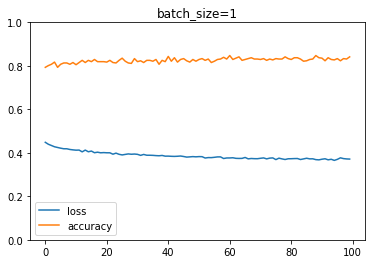

In [114]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[0]}')
plt.legend()
plt.ylim([0,1])
plt.show()

In [115]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 2ms/step - loss: 0.4718 - accuracy: 0.8131


In [116]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')
result = model.fit(X_train, T_train_onehot, batch_size=bsize[1], epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.5089
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6756 - accuracy: 0.6385
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.6956
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6174 - accuracy: 0.7169
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6064 - accuracy: 0.7020
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5554 - accuracy: 0.7530
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5376 - accuracy: 0.7775
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5346 - accuracy: 0.7787
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5362 - accuracy: 0.7632
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5202 - accuracy: 0.7666
Epoch 11/

32/32 [==============================] - 0s 1ms/step - loss: 0.4029 - accuracy: 0.8283
Epoch 84/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8401
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3834 - accuracy: 0.8378
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8192
Epoch 87/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4010 - accuracy: 0.8189
Epoch 88/100
32/32 [==============================] - 0s 996us/step - loss: 0.3825 - accuracy: 0.8257
Epoch 89/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.7980
Epoch 90/100
32/32 [==============================] - 0s 999us/step - loss: 0.4058 - accuracy: 0.8228
Epoch 91/100
32/32 [==============================] - 0s 997us/step - loss: 0.4243 - accuracy: 0.8140
Epoch 92/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7857
Epoch 9

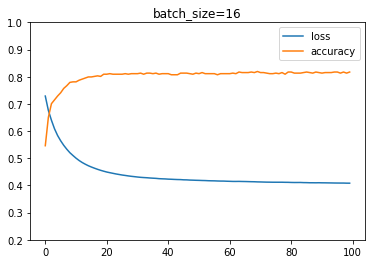

In [117]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[1]}')
plt.legend()
plt.ylim([0.2,1])
plt.show()

In [118]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7991


In [119]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')
result = model.fit(X_train, T_train_onehot, batch_size=bsize[2], epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.8488 - accuracy: 0.3961
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.8072 - accuracy: 0.4203
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.8266 - accuracy: 0.3971
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7980 - accuracy: 0.3901
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7852 - accuracy: 0.4031
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7698 - accuracy: 0.3914
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7654 - accuracy: 0.4018
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7415 - accuracy: 0.4086
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7355 - accuracy: 0.4450
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.7343 - accuracy: 0.4515
Epoch 11/100
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.4894 - accuracy: 0.7878
Epoch 85/100
4/4 [==============================] - 0s 3ms/step - loss: 0.4924 - accuracy: 0.7961
Epoch 86/100
4/4 [==============================] - 0s 3ms/step - loss: 0.5090 - accuracy: 0.7815
Epoch 87/100
4/4 [==============================] - 0s 3ms/step - loss: 0.4935 - accuracy: 0.7961
Epoch 88/100
4/4 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.7836
Epoch 89/100
4/4 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.7969
Epoch 90/100
4/4 [==============================] - 0s 2ms/step - loss: 0.4955 - accuracy: 0.7883
Epoch 91/100
4/4 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7998
Epoch 92/100
4/4 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.7868
Epoch 93/100
4/4 [==============================] - 0s 3ms/step - loss: 0.4746 - accuracy: 0.8087
Epoch 94/100
4/4 [===============

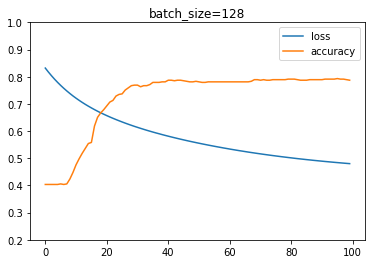

In [120]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[2]}')
plt.legend()
plt.ylim([0.2,1])
plt.show()

In [121]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.8037


In [122]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')
result = model.fit(X_train, T_train_onehot, batch_size=bsize[3], epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 283ms/step - loss: 0.7273 - accuracy: 0.5462
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.7254 - accuracy: 0.5482
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.5502
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.7216 - accuracy: 0.5502
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 0.7197 - accuracy: 0.5542
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.7179 - accuracy: 0.5582
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.7160 - accuracy: 0.5582
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.7142 - accuracy: 0.5602
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5582
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7106 - accuracy: 0.5622
Epoch 11/100
1/1 [=========

1/1 [==============================] - 0s 6ms/step - loss: 0.6143 - accuracy: 0.7048
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6133 - accuracy: 0.7068
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.7068
Epoch 87/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.7088
Epoch 88/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.7088
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6095 - accuracy: 0.7088
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6085 - accuracy: 0.7108
Epoch 91/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6076 - accuracy: 0.7088
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6067 - accuracy: 0.7129
Epoch 93/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.7149
Epoch 94/100
1/1 [===============

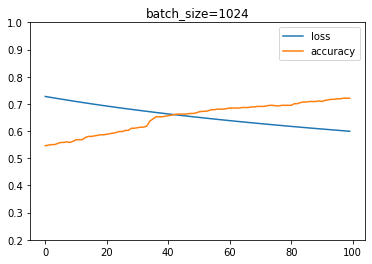

In [123]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[3]}')
plt.legend()
plt.ylim([0.2,1])
plt.show()

In [124]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 1ms/step - loss: 0.6005 - accuracy: 0.7850


【訓練データの予測結果】  
- バッチサイズ=1　→　損失0.3713　正解率0.8414
- バッチサイズ=16　→　損失0.4183　正解率0.8206
- バッチサイズ=128　→　損失0.4774　正解率0.7847
- バッチサイズ=1024　→　損失0.5994　正解率0.7209
  
【テストデータの予測結果】  
- バッチサイズ=1　→　損失0.4718　正解率0.8131
- バッチサイズ=16　→　損失0.4650　正解率0.7991
- バッチサイズ=128　→　損失0.4993　正解率0.8037
- バッチサイズ=1024　→　損失0.6005　正解率0.7850
  
バッチサイズ=1では過学習を起してテストデータでの精度が悪くなると予想したが、予想と違う結果になった。  
バッチサイズ128と1024では収束する前に学習が終わっているように見えるので、エポック数を増やしてみる。

In [125]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')
result = model.fit(X_train, T_train_onehot, batch_size=bsize[2], epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7249 - accuracy: 0.6174
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.6556
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7023 - accuracy: 0.6628
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7018 - accuracy: 0.6722
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.6770
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.6749
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.6806
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.6934
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.6719
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.7011
Epoch 11/500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.8112
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.7799
Epoch 86/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4916 - accuracy: 0.7846
Epoch 87/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4928 - accuracy: 0.7812
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4983 - accuracy: 0.7851
Epoch 89/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4854 - accuracy: 0.7963
Epoch 90/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4934 - accuracy: 0.7755
Epoch 91/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7963
Epoch 92/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4893 - accuracy: 0.7859
Epoch 93/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.7880
Epoch 94/500
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 0.4308 - accuracy: 0.8081
Epoch 168/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.8224
Epoch 169/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.8206
Epoch 170/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.8091
Epoch 171/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4536 - accuracy: 0.8047
Epoch 172/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.8083
Epoch 173/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4481 - accuracy: 0.8159
Epoch 174/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.8120
Epoch 175/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4486 - accuracy: 0.8094
Epoch 176/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.8193
Epoch 177/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.8086
Epoch 250/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.8058
Epoch 251/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8211
Epoch 252/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.8349
Epoch 253/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8209
Epoch 254/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.8112
Epoch 255/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4170 - accuracy: 0.8180
Epoch 256/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4060 - accuracy: 0.8193
Epoch 257/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4382 - accuracy: 0.8034
Epoch 258/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4254 - accuracy: 0.8105
Epoch 259/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7880
Epoch 332/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4275 - accuracy: 0.8015
Epoch 333/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4172 - accuracy: 0.8101
Epoch 334/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8114
Epoch 335/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4214 - accuracy: 0.8005
Epoch 336/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8059
Epoch 337/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8070
Epoch 338/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.7963
Epoch 339/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7992
Epoch 340/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3990 - accuracy: 0.8213
Epoch 341/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7937
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8104
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4178 - accuracy: 0.8078
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.8070
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7948
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4036 - accuracy: 0.8200
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.8068
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.7979
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.8042
Epoch 422/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4131 - accuracy: 0.8208
Epoch 423/500
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.4116 - accuracy: 0.8049
Epoch 496/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.7965
Epoch 497/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3878 - accuracy: 0.8166
Epoch 498/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8072
Epoch 499/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7944
Epoch 500/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8137


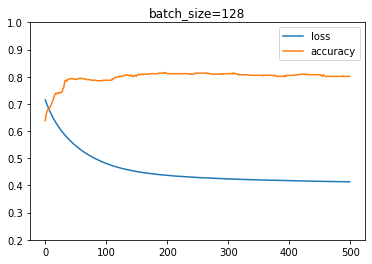

In [126]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[2]}')
plt.legend()
plt.ylim([0.2,1])
plt.show()

In [127]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.8131


In [128]:
model = Sequential()
model.add(Dense(input_dim=6, units=20, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')
result = model.fit(X_train, T_train_onehot, batch_size=bsize[3], epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.8072 - accuracy: 0.3434
Epoch 2/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8048 - accuracy: 0.3474
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8024 - accuracy: 0.3494
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8000 - accuracy: 0.3514
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7977 - accuracy: 0.3554
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7954 - accuracy: 0.3614
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7931 - accuracy: 0.3715
Epoch 8/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7908 - accuracy: 0.3735
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7886 - accuracy: 0.3775
Epoch 10/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.7863 - accuracy: 0.3775
Epoch 11/1000
1/1

1/1 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6727
Epoch 84/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6635 - accuracy: 0.6747
Epoch 85/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6623 - accuracy: 0.6787
Epoch 86/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6747
Epoch 87/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6598 - accuracy: 0.6767
Epoch 88/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6807
Epoch 89/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6573 - accuracy: 0.6867
Epoch 90/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6867
Epoch 91/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6867
Epoch 92/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6536 - accuracy: 0.6908
Epoch 93/1000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.5822 - accuracy: 0.7610
Epoch 165/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5814 - accuracy: 0.7631
Epoch 166/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5806 - accuracy: 0.7651
Epoch 167/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5798 - accuracy: 0.7671
Epoch 168/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5790 - accuracy: 0.7691
Epoch 169/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5782 - accuracy: 0.7691
Epoch 170/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7691
Epoch 171/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5767 - accuracy: 0.7691
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5759 - accuracy: 0.7691
Epoch 173/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5751 - accuracy: 0.7671
Epoch 174/1000


Epoch 246/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5299 - accuracy: 0.7831
Epoch 247/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5294 - accuracy: 0.7831
Epoch 248/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5289 - accuracy: 0.7831
Epoch 249/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5284 - accuracy: 0.7831
Epoch 250/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5279 - accuracy: 0.7831
Epoch 251/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5275 - accuracy: 0.7831
Epoch 252/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5270 - accuracy: 0.7831
Epoch 253/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5265 - accuracy: 0.7831
Epoch 254/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5260 - accuracy: 0.7831
Epoch 255/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5256 - accuracy: 0.7831


1/1 [==============================] - 0s 4ms/step - loss: 0.4976 - accuracy: 0.7831
Epoch 328/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4973 - accuracy: 0.7831
Epoch 329/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4970 - accuracy: 0.7831
Epoch 330/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4966 - accuracy: 0.7831
Epoch 331/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4963 - accuracy: 0.7851
Epoch 332/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4960 - accuracy: 0.7871
Epoch 333/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4957 - accuracy: 0.7871
Epoch 334/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7871
Epoch 335/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.7871
Epoch 336/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4948 - accuracy: 0.7871
Epoch 337/1000


1/1 [==============================] - 0s 5ms/step - loss: 0.4769 - accuracy: 0.7912
Epoch 409/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.7912
Epoch 410/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.7912
Epoch 411/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4763 - accuracy: 0.7912
Epoch 412/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4761 - accuracy: 0.7912
Epoch 413/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.7912
Epoch 414/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4757 - accuracy: 0.7912
Epoch 415/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4755 - accuracy: 0.7912
Epoch 416/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4753 - accuracy: 0.7912
Epoch 417/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4751 - accuracy: 0.7912
Epoch 418/1000


1/1 [==============================] - 0s 6ms/step - loss: 0.4634 - accuracy: 0.7952
Epoch 490/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4633 - accuracy: 0.7952
Epoch 491/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4631 - accuracy: 0.7952
Epoch 492/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7952
Epoch 493/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4629 - accuracy: 0.7952
Epoch 494/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4627 - accuracy: 0.7952
Epoch 495/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4626 - accuracy: 0.7952
Epoch 496/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4625 - accuracy: 0.7952
Epoch 497/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7952
Epoch 498/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4622 - accuracy: 0.7952
Epoch 499/1000


1/1 [==============================] - 0s 4ms/step - loss: 0.4541 - accuracy: 0.7992
Epoch 571/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4540 - accuracy: 0.7992
Epoch 572/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4539 - accuracy: 0.7992
Epoch 573/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4538 - accuracy: 0.7992
Epoch 574/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4537 - accuracy: 0.7992
Epoch 575/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4536 - accuracy: 0.7992
Epoch 576/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4535 - accuracy: 0.7992
Epoch 577/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4534 - accuracy: 0.7992
Epoch 578/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7992
Epoch 579/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4533 - accuracy: 0.8012
Epoch 580/1000


1/1 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.8012
Epoch 653/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.8012
Epoch 654/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.8012
Epoch 655/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4471 - accuracy: 0.8012
Epoch 656/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4470 - accuracy: 0.8012
Epoch 657/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4470 - accuracy: 0.8012
Epoch 658/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4469 - accuracy: 0.8012
Epoch 659/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4468 - accuracy: 0.8012
Epoch 660/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.8012
Epoch 661/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4467 - accuracy: 0.8012
Epoch 662/1000


1/1 [==============================] - 0s 6ms/step - loss: 0.4423 - accuracy: 0.8032
Epoch 734/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4422 - accuracy: 0.8032
Epoch 735/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4422 - accuracy: 0.8032
Epoch 736/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4421 - accuracy: 0.8052
Epoch 737/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4421 - accuracy: 0.8052
Epoch 738/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.8052
Epoch 739/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4419 - accuracy: 0.8052
Epoch 740/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4419 - accuracy: 0.8052
Epoch 741/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4418 - accuracy: 0.8052
Epoch 742/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4418 - accuracy: 0.8052
Epoch 743/1000


1/1 [==============================] - 0s 4ms/step - loss: 0.4381 - accuracy: 0.8052
Epoch 816/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4381 - accuracy: 0.8052
Epoch 817/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8052
Epoch 818/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8052
Epoch 819/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4379 - accuracy: 0.8052
Epoch 820/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4379 - accuracy: 0.8052
Epoch 821/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8052
Epoch 822/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4378 - accuracy: 0.8052
Epoch 823/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4378 - accuracy: 0.8052
Epoch 824/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4377 - accuracy: 0.8052
Epoch 825/1000


1/1 [==============================] - 0s 5ms/step - loss: 0.4347 - accuracy: 0.8052
Epoch 898/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4347 - accuracy: 0.8052
Epoch 899/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4347 - accuracy: 0.8052
Epoch 900/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4346 - accuracy: 0.8052
Epoch 901/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.8052
Epoch 902/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4346 - accuracy: 0.8052
Epoch 903/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.4345 - accuracy: 0.8052
Epoch 904/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4345 - accuracy: 0.8052
Epoch 905/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.4345 - accuracy: 0.8072
Epoch 906/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.4344 - accuracy: 0.8072
Epoch 907/1

1/1 [==============================] - 0s 4ms/step - loss: 0.4319 - accuracy: 0.8092
Epoch 979/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4319 - accuracy: 0.8092
Epoch 980/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4319 - accuracy: 0.8092
Epoch 981/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.8092
Epoch 982/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.8092
Epoch 983/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.8092
Epoch 984/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4317 - accuracy: 0.8092
Epoch 985/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4317 - accuracy: 0.8092
Epoch 986/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4317 - accuracy: 0.8092
Epoch 987/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4317 - accuracy: 0.8092
Epoch 988/1000


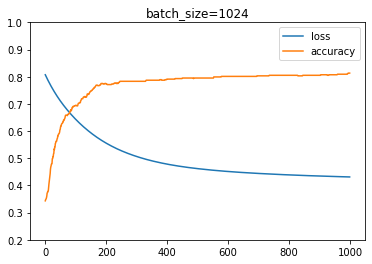

In [130]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='accuracy')
plt.title(f'batch_size={bsize[3]}')
plt.legend()
plt.ylim([0.2,1])
plt.show()

In [131]:
loss, accuracy = model.evaluate(X_test, T_test_onehot)

7/7 [==============================] - 0s 1ms/step - loss: 0.4724 - accuracy: 0.7850


【訓練データの予測結果】  
- バッチサイズ=1　→　損失0.3713　正解率0.8414
- バッチサイズ=16　→　損失0.4183　正解率0.8206
- バッチサイズ=128　→　損失0.4034　正解率0.8137（前回：損失0.4774　正解率0.7847）
- バッチサイズ=1024　→　損失0.4312　正解率0.8133（前回：損失0.5994　正解率0.7209）
  
【テストデータの予測結果】  
- バッチサイズ=1　→　損失0.4718　正解率0.8131
- バッチサイズ=16　→　損失0.4650　正解率0.7991
- バッチサイズ=128　→　損失0.4676　正解率0.8131（前回：損失0.4993　正解率0.8037）
- バッチサイズ=1024　→　損失0.4724　正解率0.7850（前回：損失0.6005　正解率0.7850）
  
バッチサイズ128と1024についてエポック数を増やしたところ、訓練データの精度は上がったがテストデータではあまり変化がなかった。  
最初に予想していたエポック毎のばらつきもあまり見られず、バッチサイズをどう決めたらいいのかは結論が出なかった。

### エポック数の決め方を考える
エポック数は多すぎると過学習を起こすらしい。  
精度の向上が小さくなってくると自動的に学習を止めるEarly Stoppingという方法がある。

バッチサイズ:1,16,128それぞれでEarly Stoppingを試し、エポック数を比較する。

In [97]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1) # 3回続けて損失が減少しなくなれば、学習を終了させる

In [101]:
model1 = Sequential()
model1.add(Dense(input_dim=6, units=20, activation='relu'))
model1.add(Dense(units=2, activation='sigmoid'))
model1.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')

result1 = model1.fit(X_train, T_train_onehot, batch_size=bsize[0], epochs=50, callbacks=[callback], validation_split=0.1)

Epoch 1/50
448/448 [==============================] - 1s 1ms/step - loss: 0.6151 - accuracy: 0.7196 - val_loss: 0.4755 - val_accuracy: 0.8200
Epoch 2/50
448/448 [==============================] - 1s 1ms/step - loss: 0.4625 - accuracy: 0.7853 - val_loss: 0.4592 - val_accuracy: 0.8000
Epoch 3/50
448/448 [==============================] - 1s 1ms/step - loss: 0.4433 - accuracy: 0.8092 - val_loss: 0.4316 - val_accuracy: 0.8200
Epoch 4/50
448/448 [==============================] - 1s 1ms/step - loss: 0.4232 - accuracy: 0.8144 - val_loss: 0.4619 - val_accuracy: 0.8200
Epoch 5/50
448/448 [==============================] - 1s 1ms/step - loss: 0.4160 - accuracy: 0.8138 - val_loss: 0.4297 - val_accuracy: 0.8400
Epoch 6/50
448/448 [==============================] - 1s 1ms/step - loss: 0.3977 - accuracy: 0.7991 - val_loss: 0.4404 - val_accuracy: 0.8600
Epoch 7/50
448/448 [==============================] - 1s 1ms/step - loss: 0.4254 - accuracy: 0.8168 - val_loss: 0.4548 - val_accuracy: 0.8800
Epoch 

In [102]:
model2 = Sequential()
model2.add(Dense(input_dim=6, units=20, activation='relu'))
model2.add(Dense(units=2, activation='sigmoid'))
model2.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')

result2 = model2.fit(X_train, T_train_onehot, batch_size=bsize[1], epochs=200, callbacks=[callback], validation_split=0.1)

Epoch 1/200
28/28 [==============================] - 0s 7ms/step - loss: 0.7384 - accuracy: 0.5802 - val_loss: 0.6999 - val_accuracy: 0.5600
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5768 - val_loss: 0.6525 - val_accuracy: 0.7000
Epoch 3/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6551 - val_loss: 0.6168 - val_accuracy: 0.8000
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.7017 - val_loss: 0.5895 - val_accuracy: 0.8600
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.5859 - accuracy: 0.7892 - val_loss: 0.5678 - val_accuracy: 0.8400
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.7604 - val_loss: 0.5502 - val_accuracy: 0.8400
Epoch 7/200
28/28 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.7522 - val_loss: 0.5356 - val_accuracy: 0.8200
Epoch 8/200
2

In [103]:
model3 = Sequential()
model3.add(Dense(input_dim=6, units=20, activation='relu'))
model3.add(Dense(units=2, activation='sigmoid'))
model3.compile(optimizer=SGD(lr=0.02), loss='binary_crossentropy', metrics='accuracy')

result3 = model3.fit(X_train, T_train_onehot, batch_size=bsize[2], epochs=500, callbacks=[callback], validation_split=0.1)

Epoch 1/500
4/4 [==============================] - 0s 51ms/step - loss: 0.8169 - accuracy: 0.3298 - val_loss: 0.8232 - val_accuracy: 0.4200
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 0.7954 - accuracy: 0.3756 - val_loss: 0.8144 - val_accuracy: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7921 - accuracy: 0.3984 - val_loss: 0.8058 - val_accuracy: 0.5000
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7851 - accuracy: 0.4071 - val_loss: 0.7974 - val_accuracy: 0.5000
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.7783 - accuracy: 0.4353 - val_loss: 0.7894 - val_accuracy: 0.5200
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.7699 - accuracy: 0.4380 - val_loss: 0.7818 - val_accuracy: 0.5200
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7652 - accuracy: 0.4733 - val_loss: 0.7743 - val_accuracy: 0.5200
Epoch 8/500
4/4 [===

Epoch 59/500
4/4 [==============================] - 0s 14ms/step - loss: 0.5608 - accuracy: 0.7919 - val_loss: 0.5623 - val_accuracy: 0.8200
Epoch 60/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5519 - accuracy: 0.8082 - val_loss: 0.5600 - val_accuracy: 0.8200
Epoch 61/500
4/4 [==============================] - 0s 14ms/step - loss: 0.5508 - accuracy: 0.7997 - val_loss: 0.5579 - val_accuracy: 0.8400
Epoch 62/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5495 - accuracy: 0.7980 - val_loss: 0.5558 - val_accuracy: 0.8400
Epoch 63/500
4/4 [==============================] - 0s 14ms/step - loss: 0.5425 - accuracy: 0.8169 - val_loss: 0.5538 - val_accuracy: 0.8400
Epoch 64/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5540 - accuracy: 0.7919 - val_loss: 0.5517 - val_accuracy: 0.8400
Epoch 65/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5477 - accuracy: 0.8020 - val_loss: 0.5497 - val_accuracy: 0.8400
Epoch 66/500


Epoch 117/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4707 - accuracy: 0.8042 - val_loss: 0.4783 - val_accuracy: 0.8400
Epoch 118/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4705 - accuracy: 0.8134 - val_loss: 0.4774 - val_accuracy: 0.8400
Epoch 119/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4663 - accuracy: 0.8089 - val_loss: 0.4766 - val_accuracy: 0.8400
Epoch 120/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4778 - accuracy: 0.7975 - val_loss: 0.4758 - val_accuracy: 0.8400
Epoch 121/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4850 - accuracy: 0.7795 - val_loss: 0.4750 - val_accuracy: 0.8400
Epoch 122/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4632 - accuracy: 0.8019 - val_loss: 0.4743 - val_accuracy: 0.8400
Epoch 123/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4812 - accuracy: 0.7957 - val_loss: 0.4734 - val_accuracy: 0.8400
Epoch 

Epoch 175/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4473 - accuracy: 0.8132 - val_loss: 0.4463 - val_accuracy: 0.8000
Epoch 176/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4524 - accuracy: 0.8007 - val_loss: 0.4459 - val_accuracy: 0.8000
Epoch 177/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4331 - accuracy: 0.8181 - val_loss: 0.4456 - val_accuracy: 0.8000
Epoch 178/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4515 - accuracy: 0.8001 - val_loss: 0.4454 - val_accuracy: 0.7800
Epoch 179/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4231 - accuracy: 0.8276 - val_loss: 0.4451 - val_accuracy: 0.7800
Epoch 180/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4426 - accuracy: 0.8078 - val_loss: 0.4448 - val_accuracy: 0.7800
Epoch 181/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4563 - accuracy: 0.7940 - val_loss: 0.4445 - val_accuracy: 0.7800
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4319 - accuracy: 0.8099 - val_loss: 0.4336 - val_accuracy: 0.7800
Epoch 234/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4120 - accuracy: 0.8235 - val_loss: 0.4337 - val_accuracy: 0.7800
Epoch 235/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4378 - accuracy: 0.7920 - val_loss: 0.4337 - val_accuracy: 0.7800
Epoch 236/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4259 - accuracy: 0.8071 - val_loss: 0.4336 - val_accuracy: 0.7800
Epoch 237/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4368 - accuracy: 0.8011 - val_loss: 0.4335 - val_accuracy: 0.7800
Epoch 238/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4212 - accuracy: 0.8153 - val_loss: 0.4333 - val_accuracy: 0.7800
Epoch 239/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4120 - accuracy: 0.8265 - val_loss: 0.4331 - val_accuracy: 0.7800
Epoch 

IndexError: list index out of range

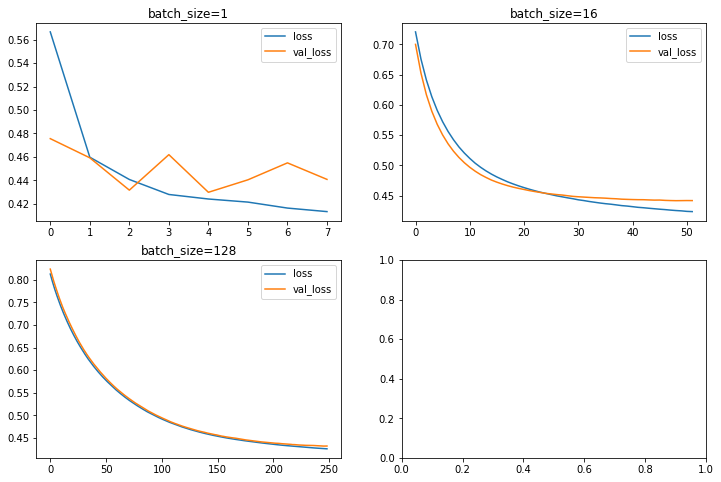

In [112]:
fig = plt.figure(figsize=(12,8))
#fig.add_subplot()
results=[result1,result2,result3]

i = 0
for b in bsize:
    plt.subplot(2,2,i+1)
    plt.plot(results[i].history['loss'], label='loss')
    plt.plot(results[i].history['val_loss'], label='val_loss')
    plt.title(f'batch_size={b}')
    plt.legend()
#    plt.ylim([0,1])
    i=i+1
plt.show()

訓練データに対する予測の損失(loss)は学習を繰り返せば繰り返すほど減少するが、バリデーションデータに対する予測の損失(val_loss)はあるところから減少幅が小さくなっている。  
EarlyStoppingを使って自動的にエポック数を決定できることを確認できた。